<a href="https://colab.research.google.com/github/driano1221/Desafio-de-Machine-Learning/blob/main/Modelo_Classifica%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Estatística descritiva breve para rupturas_minimo.xlsx (Google Colab) ---


import pandas as pd
import numpy as np
import re

# Caminho do arquivo (como você indicou):
path = "/content/drive/MyDrive/Colab Notebooks/rupturas_minimo.xlsx"

# Leitura
df = pd.read_excel(path)  # engine="openpyxl" será usado automaticamente no Colab
print(df)
# --- Validações e preparo ---
# Esperado: ['registro', 'tipo', 'p1'...'p7']
expected_tipo = {"a1","a2","b","c","d","e","f","g","h"}
p_cols = [c for c in df.columns if re.fullmatch(r"p[1-7]", str(c))]
if not p_cols:
    raise ValueError("Não encontrei colunas p1..p7. Verifique o arquivo.")

# Converte flags p1..p7 para numérico (0/1), preservando NA se houver
df[p_cols] = df[p_cols].apply(pd.to_numeric, errors="coerce")

# Número de particularidades por registro
df["n_particularidades"] = df[p_cols].sum(axis=1)

# --- 1) Visão geral ---
print("=== VISÃO GERAL ===")
print("Formato (linhas, colunas):", df.shape)
print("\nColunas:", list(df.columns))
print("\nTipos de dados:")
print(df.dtypes)

print("\nValores ausentes por coluna:")
print(df.isna().sum())

# --- 2) Distribuição de 'tipo' ---
print("\n=== DISTRIBUIÇÃO DE 'tipo' ===")
tipo_counts = df["tipo"].value_counts(dropna=False).sort_index()
tipo_pct = (df["tipo"].value_counts(normalize=True, dropna=False).sort_index() * 100).round(2)
print(pd.DataFrame({"contagem": tipo_counts, "percentual_%": tipo_pct}))

# --- 3) Flags de particularidades (p1..p7) ---
print("\n=== FLAGS p1..p7 (geral) ===")
flags_summary = pd.DataFrame({
    "soma": df[p_cols].sum(),
    "proporcao_%": (df[p_cols].mean() * 100).round(2)
}).astype({"soma": int})
print(flags_summary)

# --- 4) Número de particularidades por registro ---
print("\n=== Nº de particularidades por registro ===")
npart_counts = df["n_particularidades"].value_counts().sort_index()
npart_pct = (df["n_particularidades"].value_counts(normalize=True).sort_index() * 100).round(2)
print(pd.DataFrame({"contagem": npart_counts, "percentual_%": npart_pct}))

# --- 5) Perfil por 'tipo': média das flags (% de ocorrência) e n por tipo ---
print("\n=== PERFIL POR 'tipo' (média das flags como %) ===")
tipo_n = df["tipo"].value_counts().rename("n")
tipo_flags = (df.groupby("tipo")[p_cols].mean() * 100).round(1)
perfil_tipo = tipo_flags.merge(tipo_n, left_index=True, right_index=True)
# Ordena por n desc para facilitar leitura
perfil_tipo = perfil_tipo.sort_values("n", ascending=False)
print(perfil_tipo)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/rupturas_minimo.xlsx'

## Projeto de fato


In [ ]:
# Importando as bibliotecas necessárias
import os
import pandas as pd
import shutil
import glob # Ótimo para encontrar arquivos com padrões específicos

# Montar o Google Drive no ambiente do Colab
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- CAMINHOS QUE VOCÊ PRECISA CONFIGURAR ---

# Caminho para o seu arquivo Excel com os rótulos
caminho_excel = "/content/drive/MyDrive/Colab Notebooks/rupturas_minimo.xlsx"

# Caminho para a pasta onde TODAS as imagens de vistas estão juntas
pasta_origem_imagens = "/content/drive/MyDrive/Colab Notebooks/vistas_separadas"

# Caminho para a nova pasta que será criada para armazenar o dataset organizado
# Vamos criar esta pasta fora do Drive para maior velocidade de acesso durante o treinamento.
# Se preferir salvar no Drive, altere para: '/content/drive/MyDrive/Colab Notebooks/dataset_organizado'
pasta_destino_dataset = "/content/dataset_organizado"



In [ ]:
# Carregar a planilha para um DataFrame do Pandas
try:
    df_rupturas = pd.read_excel(caminho_excel)
    # print(df_rupturas.head()) # Descomente para ver as primeiras linhas
except FileNotFoundError:
    print(f"ERRO: O arquivo Excel não foi encontrado em: {caminho_excel}")
    # Interrompe a execução se o arquivo não for encontrado
    raise

# Obter os nomes únicos das classes de ruptura da coluna 'tipo'
tipos_unicos = df_rupturas['tipo'].unique()

print("\nTipos de ruptura encontrados:", tipos_unicos)

# Criar a pasta principal do dataset, se ela não existir
os.makedirs(pasta_destino_dataset, exist_ok=True)

# Criar uma subpasta para cada tipo de ruptura
for tipo in tipos_unicos:
    caminho_da_classe = os.path.join(pasta_destino_dataset, str(tipo))
    os.makedirs(caminho_da_classe, exist_ok=True)




Tipos de ruptura encontrados: ['a1' 'a2' 'e' 'd' 'f' 'g']


In [ ]:
print("Iniciando a organização das imagens. Isso pode levar alguns minutos...")

# Contador para verificar o sucesso da operação
imagens_copiadas = 0
imagens_nao_encontradas_no_df = 0

# Criar um mapeamento de 'registro' para 'tipo' para acesso rápido
# Isso é muito mais eficiente do que pesquisar o DataFrame a cada iteração
mapeamento_registro_tipo = pd.Series(df_rupturas.tipo.values, index=df_rupturas.registro).to_dict()

# Encontrar todos os arquivos .jpg na pasta de origem
lista_de_imagens = glob.glob(os.path.join(pasta_origem_imagens, '*.jpg'))

if not lista_de_imagens:
    print(f"AVISO: Nenhuma imagem .jpg foi encontrada na pasta de origem: {pasta_origem_imagens}")

for caminho_imagem_origem in lista_de_imagens:
    try:
        # Extrair o nome do arquivo (ex: '657_vista4.jpg')
        nome_arquivo = os.path.basename(caminho_imagem_origem)

        # Extrair o número do registro do nome do arquivo
        registro_id = int(nome_arquivo.split('_')[0])

        # Encontrar o tipo de ruptura usando nosso mapeamento
        if registro_id in mapeamento_registro_tipo:
            tipo_ruptura = mapeamento_registro_tipo[registro_id]

            # Construir o caminho completo de destino
            caminho_final = os.path.join(pasta_destino_dataset, str(tipo_ruptura), nome_arquivo)

            # Copiar o arquivo
            shutil.copy(caminho_imagem_origem, caminho_final)
            imagens_copiadas += 1
        else:
            # Caso o registro da imagem não esteja na planilha
            print(f"Aviso: Registro {registro_id} (do arquivo {nome_arquivo}) não encontrado na planilha.")
            imagens_nao_encontradas_no_df += 1

    except (ValueError, IndexError) as e:
        print(f"Aviso: Não foi possível processar o arquivo '{nome_arquivo}'. Verifique o padrão de nome. Erro: {e}")

print("\n--- Processo Finalizado! ---")
print(f"Total de imagens copiadas com sucesso: {imagens_copiadas}")
print(f"Imagens cujo registro não foi encontrado na planilha: {imagens_nao_encontradas_no_df}")

Iniciando a organização das imagens. Isso pode levar alguns minutos...
Aviso: Registro 716 (do arquivo 716_vista5.jpg) não encontrado na planilha.
Aviso: Registro 716 (do arquivo 716_vista3.jpg) não encontrado na planilha.
Aviso: Registro 716 (do arquivo 716_vista2.jpg) não encontrado na planilha.
Aviso: Registro 716 (do arquivo 716_vista4.jpg) não encontrado na planilha.
Aviso: Registro 717 (do arquivo 717_vista2.jpg) não encontrado na planilha.
Aviso: Registro 717 (do arquivo 717_vista3.jpg) não encontrado na planilha.
Aviso: Registro 717 (do arquivo 717_vista5.jpg) não encontrado na planilha.
Aviso: Registro 717 (do arquivo 717_vista4.jpg) não encontrado na planilha.

--- Processo Finalizado! ---
Total de imagens copiadas com sucesso: 527
Imagens cujo registro não foi encontrado na planilha: 8


In [ ]:
print("--- Verificação Final: Contagem de imagens por classe ---")

total_imagens_organizadas = 0

# Itera sobre as pastas de cada classe que foram criadas
for nome_pasta in sorted(os.listdir(pasta_destino_dataset)):
    caminho_pasta_classe = os.path.join(pasta_destino_dataset, nome_pasta)

    # Verifica se é um diretório
    if os.path.isdir(caminho_pasta_classe):
        # Conta o número de arquivos na pasta
        num_arquivos = len(os.listdir(caminho_pasta_classe))
        print(f"Classe '{nome_pasta}': {num_arquivos} imagens")
        total_imagens_organizadas += num_arquivos

print("---------------------------------------------------------")
print(f"Total de imagens no dataset organizado: {total_imagens_organizadas}")

--- Verificação Final: Contagem de imagens por classe ---
Classe 'a1': 26 imagens
Classe 'a2': 275 imagens
Classe 'd': 45 imagens
Classe 'e': 58 imagens
Classe 'f': 8 imagens
Classe 'g': 115 imagens
---------------------------------------------------------
Total de imagens no dataset organizado: 527


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import mobilenet_v2

# ==============================================================================
# 1. CONFIGURAÇÃO
# ==============================================================================
# Ajuste estes parâmetros conforme necessário.

# Onde o dataset organizado no Passo 2 está localizado.
BASE_DATA_DIR = "/content/dataset_organizado"

# Classes a serem utilizadas nesta primeira "prova de conceito".
VIABLE_CLASSES = ['a2', 'g', 'e', 'd']

# Parâmetros para o modelo e o gerador de dados.
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.20  # 20% dos dados serão usados para validação.
RANDOM_STATE = 42      # Para reprodutibilidade da divisão dos dados.


# ==============================================================================
# 2. CARREGAMENTO E FILTRAGEM DOS DADOS
# ==============================================================================
# Coleta os caminhos de todas as imagens e os filtra pelas classes viáveis.

all_image_paths = []
all_labels = []

print(f"Buscando imagens em: {BASE_DATA_DIR}")
print(f"Filtrando apenas para as classes: {VIABLE_CLASSES}\n")

for class_label in os.listdir(BASE_DATA_DIR):
    if class_label in VIABLE_CLASSES:
        class_dir = os.path.join(BASE_DATA_DIR, class_label)
        for image_file in os.listdir(class_dir):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_image_paths.append(os.path.join(class_dir, image_file))
                all_labels.append(class_label)

# Verificação inicial
if not all_image_paths:
    raise FileNotFoundError(f"Nenhuma imagem encontrada para as classes viáveis em '{BASE_DATA_DIR}'. Verifique o caminho.")

print(f"Total de imagens encontradas para as classes viáveis: {len(all_image_paths)}")




Buscando imagens em: /content/dataset_organizado
Filtrando apenas para as classes: ['a2', 'g', 'e', 'd']

Total de imagens encontradas para as classes viáveis: 493


In [ ]:
# ==============================================================================
# 3. DIVISÃO ESTRATIFICADA DOS DADOS
# ==============================================================================
# Divide os dados em conjuntos de treino e validação mantendo a proporção
# original das classes em ambos os conjuntos.

X_train, X_val, y_train, y_val = train_test_split(
    all_image_paths,
    all_labels,
    test_size=VALIDATION_SPLIT,
    random_state=RANDOM_STATE,
    stratify=all_labels  # Garante a proporção das classes.
)

# Cria DataFrames para alimentar os geradores, uma prática profissional e robusta.
train_df = pd.DataFrame({'filepath': X_train, 'class': y_train})
validation_df = pd.DataFrame({'filepath': X_val, 'class': y_val})

print("\n--- Distribuição das Classes Após Divisão ---")
print("\nConjunto de Treino:")
print(train_df['class'].value_counts(normalize=True).round(3))
print(f"\nTotal de treino: {len(train_df)} imagens")

print("\nConjunto de Validação:")
print(validation_df['class'].value_counts(normalize=True).round(3))
print(f"Total de validação: {len(validation_df)} imagens\n")


# ==============================================================================
# 4. CRIAÇÃO DOS GERADORES DE IMAGEM (ImageDataGenerator)
# ==============================================================================
# Configura os geradores que irão carregar, pré-processar e aumentar os dados
# em tempo real durante o treinamento.

# Gerador para o conjunto de treino com Data Augmentation "cuidadoso".
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2],
    horizontal_flip=False,  # Essencial: não inverter a imagem.
    vertical_flip=False,    # Essencial: não inverter a imagem.
    fill_mode='reflect',
    preprocessing_function=mobilenet_v2.preprocess_input # Normaliza os pixels para o padrão do MobileNetV2 [-1, 1].
)

# Gerador para o conjunto de validação, sem Data Augmentation.
# Apenas a normalização de pixels é aplicada.
validation_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_v2.preprocess_input
)

# Cria os geradores a partir dos DataFrames.
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='class',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='filepath',
    y_col='class',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Não é necessário embaralhar os dados de validação.
)

# ==============================================================================
# 5. VERIFICAÇÃO FINAL
# ==============================================================================
print("\n--- Status Final do Passo 3 ---")
print(f"Gerador de treino pronto: {train_generator.n} imagens em {len(train_generator.class_indices)} classes, divididas em {len(train_generator)} lotes.")
print(f"Gerador de validação pronto: {validation_generator.n} imagens em {len(validation_generator.class_indices)} classes, divididas em {len(validation_generator)} lotes.")



--- Distribuição das Classes Após Divisão ---

Conjunto de Treino:
class
a2    0.558
g     0.234
e     0.117
d     0.091
Name: proportion, dtype: float64

Total de treino: 394 imagens

Conjunto de Validação:
class
a2    0.556
g     0.232
e     0.121
d     0.091
Name: proportion, dtype: float64
Total de validação: 99 imagens

Found 394 validated image filenames belonging to 4 classes.
Found 99 validated image filenames belonging to 4 classes.

--- Status Final do Passo 3 ---
Gerador de treino pronto: 394 imagens em 4 classes, divididas em 13 lotes.
Gerador de validação pronto: 99 imagens em 4 classes, divididas em 4 lotes.


### Testando e validando passo 3

Visualizando um lote de imagens do gerador de treino...


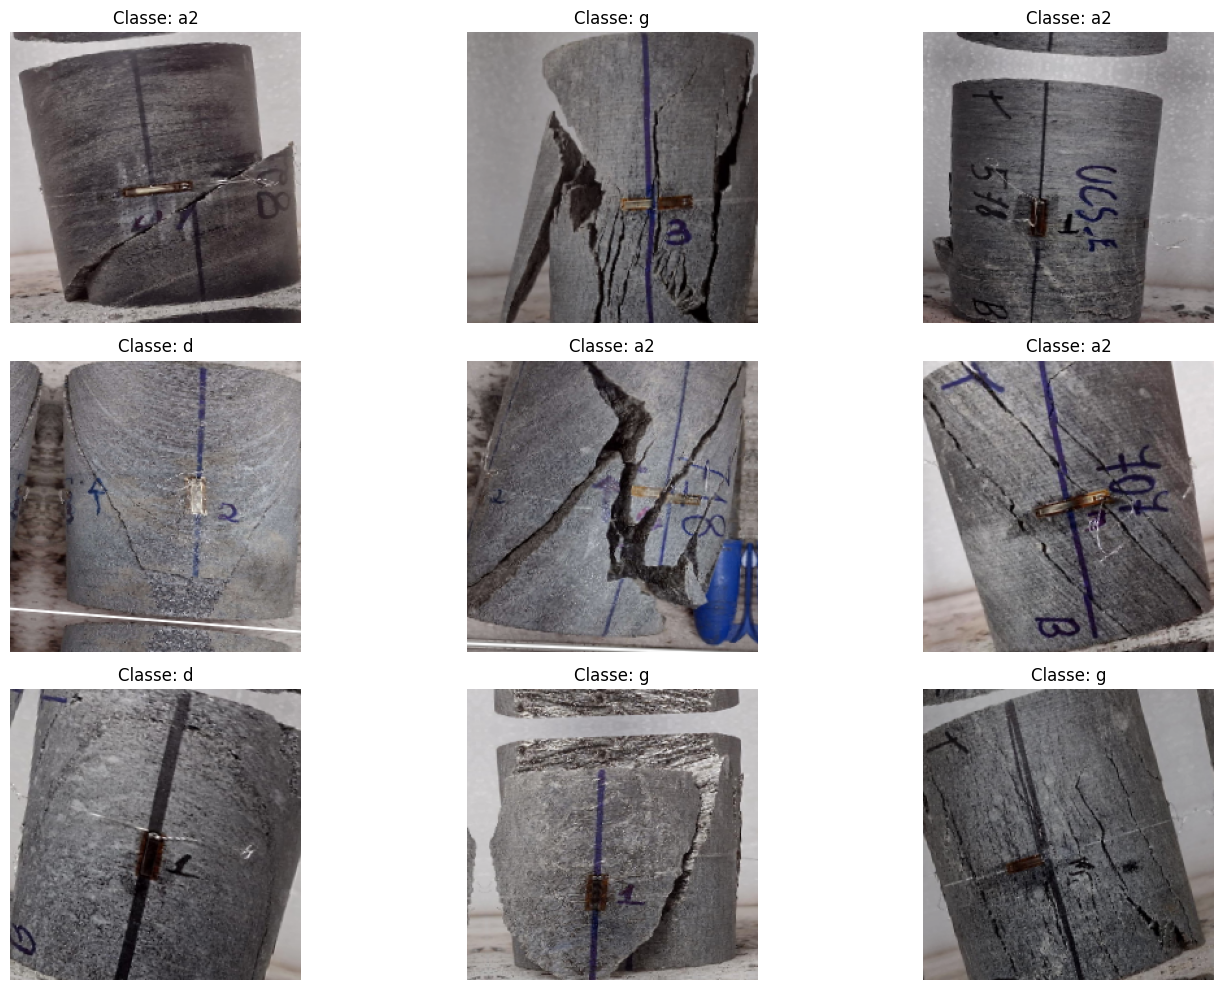


Forma do lote de imagens (Batch, Altura, Largura, Canais): (32, 224, 224, 3)
Forma do lote de rótulos (Batch, Num_Classes): (32, 4)
Intervalo de valores dos pixels (Min): -1.00
Intervalo de valores dos pixels (Max): 1.00


In [ ]:
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# CÓDIGO DE VISUALIZAÇÃO
# ------------------------------------------------------------------------------

print("Visualizando um lote de imagens do gerador de treino...")

# Pega o próximo lote de imagens e rótulos do gerador.
images, labels = next(train_generator)

# Inverte o dicionário de classes para mapear o índice de volta para o nome da classe.
# Ex: {0: 'a2', 1: 'd', 2: 'e', 3: 'g'}
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}

# Define o tamanho da grade de visualização.
plt.figure(figsize=(15, 10))

# Mostra as 9 primeiras imagens do lote.
for i in range(min(9, len(images))):
    ax = plt.subplot(3, 3, i + 1)

    # O pré-processamento do MobileNetV2 converte os pixels para o intervalo [-1, 1].
    # Para visualizar corretamente com Matplotlib, precisamos reescalar para [0, 1].
    img_to_show = (images[i] + 1) / 2.0

    plt.imshow(img_to_show)

    # Encontra o índice da classe (que é a posição do valor '1' no array one-hot)
    # e usa o dicionário invertido para obter o nome da classe.
    class_idx = np.argmax(labels[i])
    class_name = idx_to_class[class_idx]

    plt.title(f"Classe: {class_name}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Opcional: Inspecionar a forma e o intervalo dos dados de um lote.
print(f"\nForma do lote de imagens (Batch, Altura, Largura, Canais): {images.shape}")
print(f"Forma do lote de rótulos (Batch, Num_Classes): {labels.shape}")
print(f"Intervalo de valores dos pixels (Min): {images.min():.2f}")
print(f"Intervalo de valores dos pixels (Max): {images.max():.2f}")

## Passo 4

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight


# ==============================================================================
# 1. CONFIGURAÇÃO DO TREINAMENTO
# ==============================================================================
# Hiperparâmetros para o processo de treinamento.

LEARNING_RATE = 0.001
EPOCHS = 50  # Um número máximo de épocas. O EarlyStopping provavelmente irá parar antes.
EARLY_STOPPING_PATIENCE = 10 # Número de épocas sem melhora para parar o treino.
MODEL_CHECKPOINT_PATH = 'best_model_proof_of_concept.keras' # Onde salvar o melhor modelo.

# Obter o número de classes diretamente do gerador.
NUM_CLASSES = len(train_generator.class_indices)


# ==============================================================================
# 2. CÁLCULO DOS PESOS DE CLASSE (CLASS WEIGHTS)
# ==============================================================================
# Essencial para lidar com o dataset desbalanceado. Isso força o modelo a dar
# mais importância às classes com menos amostras.

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Converte para o formato de dicionário que o Keras espera.
class_weights_dict = dict(enumerate(class_weights))

print("Pesos calculados para as classes (para combater desbalanceamento):")
for i, weight in class_weights_dict.items():
    class_name = [k for k, v in train_generator.class_indices.items() if v == i][0]
    print(f"  - Classe '{class_name}' (ID: {i}): Peso = {weight:.2f}")
print("-" * 50)




Pesos calculados para as classes (para combater desbalanceamento):
  - Classe 'a2' (ID: 0): Peso = 0.45
  - Classe 'd' (ID: 1): Peso = 2.74
  - Classe 'e' (ID: 2): Peso = 2.14
  - Classe 'g' (ID: 3): Peso = 1.07
--------------------------------------------------


In [ ]:
# ==============================================================================
# 3. CONSTRUÇÃO DO MODELO (TRANSFER LEARNING)
# ==============================================================================
# Carrega o MobileNetV2 pré-treinado e adiciona um novo classificador no topo.

# Carrega o modelo base sem a sua camada de classificação (include_top=False).
base_model = MobileNetV2(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# Congela os pesos do modelo base. Eles não serão treinados nesta fase.
base_model.trainable = False

# Cria o novo modelo sequencialmente.
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.4),  # Dropout para regularização e combate ao overfitting.
    Dense(128, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax') # Camada de saída com neurônios = num_classes.
])

# ==============================================================================
# 4. COMPILAÇÃO DO MODELO
# ==============================================================================
# Define o otimizador, a função de perda e as métricas a serem monitoradas.

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Exibe um resumo da arquitetura do modelo.
model.summary()
print("-" * 50)




9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

--------------------------------------------------


In [ ]:
# ==============================================================================
# 5. DEFINIÇÃO DOS CALLBACKS
# ==============================================================================
# Callbacks são ações automáticas durante o treinamento para torná-lo mais
# eficiente e robusto.

callbacks = [
    # Para o treinamento se a perda na validação não melhorar após 'patience' épocas.
    EarlyStopping(
        monitor='val_loss',
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True # Restaura os pesos do modelo da melhor época.
    ),
    # Salva o melhor modelo encontrado durante o treinamento.
    ModelCheckpoint(
        filepath=MODEL_CHECKPOINT_PATH,
        monitor='val_loss',
        save_best_only=True
    ),
    # Reduz a taxa de aprendizado se o treinamento estagnar.
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2, # Reduz o LR por um fator de 5.
        patience=5
    )
]

# ==============================================================================
# 6. TREINAMENTO DO MODELO
# ==============================================================================
print("Iniciando o treinamento do modelo...")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weights_dict # Aplica os pesos para balanceamento.
)

print("-" * 50)
print(f"Treinamento concluído. O melhor modelo foi salvo em '{MODEL_CHECKPOINT_PATH}'.")
print("O histórico de treinamento está disponível na variável 'history'.")

Iniciando o treinamento do modelo...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.2807 - loss: 2.0576 - val_accuracy: 0.4747 - val_loss: 1.2937 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.4050 - loss: 1.3499 - val_accuracy: 0.5859 - val_loss: 1.0307 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.5192 - loss: 1.1446 - val_accuracy: 0.5657 - val_loss: 1.1177 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.5314 - loss: 1.0505 - val_accuracy: 0.5960 - val_loss: 0.9372 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.5632 - loss: 1.0562 - val_accuracy: 0.5657 - val_loss: 0.9823 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.6459 - loss: 0.9418 - val_accuracy: 0.6061 - val_loss: 0.9859 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.6223 - loss: 0.8985 - val_accuracy: 

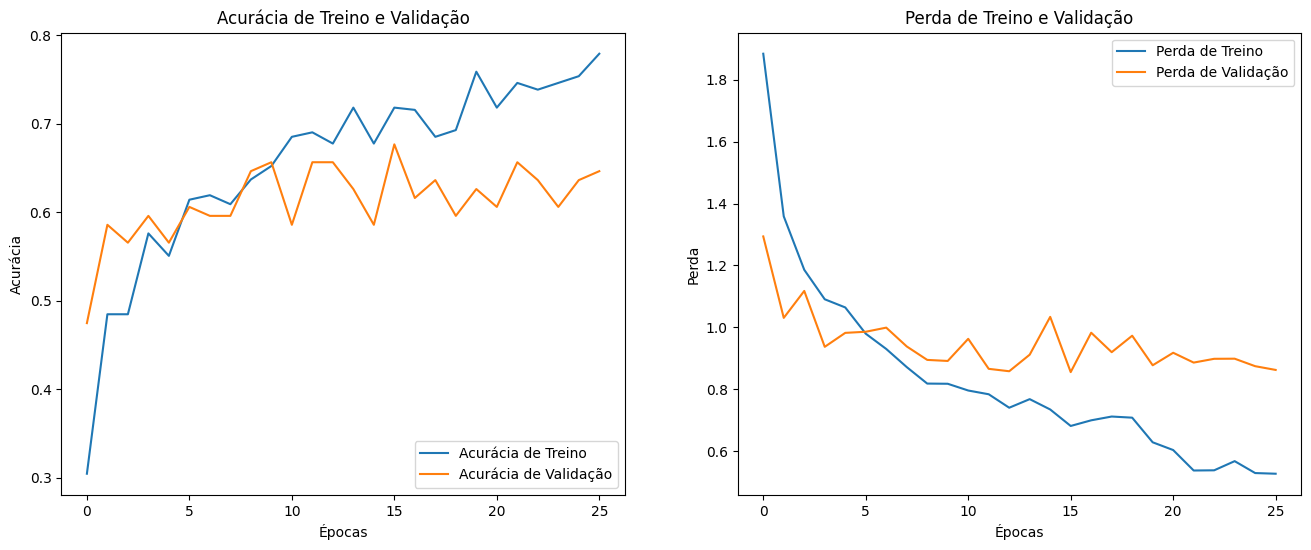

In [ ]:
import matplotlib.pyplot as plt

# --- Função para plotar o histórico de treinamento ---
def plotar_historico(history):
    """Plota os gráficos de acurácia e perda do treinamento e validação."""

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 6))

    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Acurácia de Treino')
    plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
    plt.legend(loc='lower right')
    plt.title('Acurácia de Treino e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')

    # Gráfico de Perda (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Perda de Treino')
    plt.plot(epochs_range, val_loss, label='Perda de Validação')
    plt.legend(loc='upper right')
    plt.title('Perda de Treino e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')

    plt.show()

# Chame a função com o histórico do seu treinamento
plotar_historico(history)

--- Iniciando Passo 5: Análise do Melhor Modelo do Treino Inicial ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step

Relatório de Classificação:
              precision    recall  f1-score   support

          a2       0.85      0.75      0.80        55
           d       1.00      0.22      0.36         9
           e       0.38      0.50      0.43        12
           g       0.55      0.78      0.64        23

    accuracy                           0.68        99
   macro avg       0.69      0.56      0.56        99
weighted avg       0.74      0.68      0.68        99



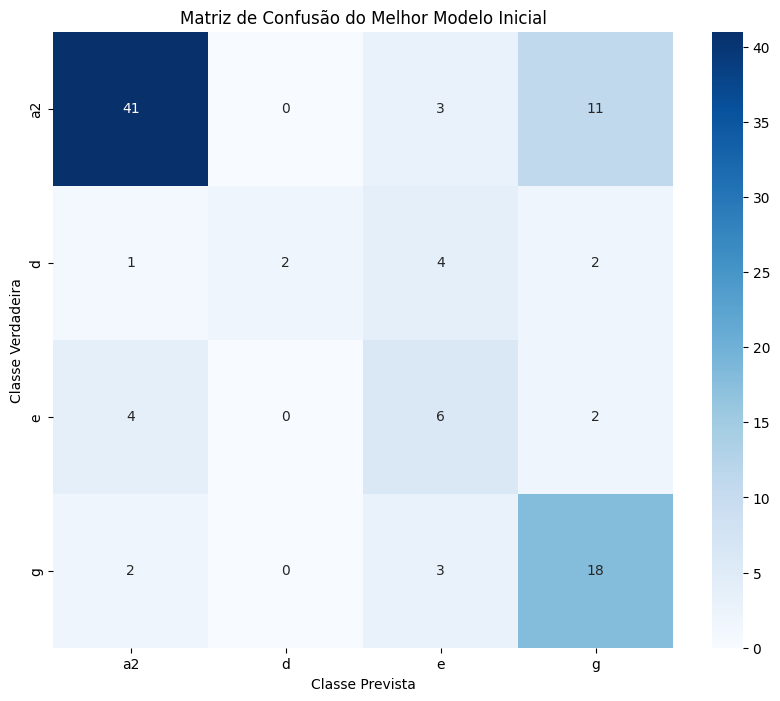

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ==============================================================================
# 1. CONFIGURAÇÃO
# ==============================================================================
# Parâmetros para as fases de avaliação e fine-tuning.

# Carrega o caminho do melhor modelo salvo no Passo 4.
BEST_MODEL_PATH = 'best_model_proof_of_concept.keras'

# Parâmetros para o fine-tuning.
FINE_TUNE_EPOCHS = 30
FINE_TUNE_LEARNING_RATE = 0.0001 # Taxa de aprendizado 10x menor que a inicial.
FINE_TUNE_CHECKPOINT_PATH = 'best_model_fine_tuned.keras'
NUM_LAYERS_TO_UNFREEZE = 30 # Número de camadas a serem "descongeladas" no final do MobileNetV2.


# ==============================================================================
# PASSO 5: ANÁLISE DETALHADA DO MELHOR MODELO INICIAL
# ==============================================================================
print("--- Iniciando Passo 5: Análise do Melhor Modelo do Treino Inicial ---")

# Carrega o melhor modelo salvo.
try:
    model = tf.keras.models.load_model(BEST_MODEL_PATH)
except Exception as e:
    print(f"Erro ao carregar o modelo. Verifique se o arquivo '{BEST_MODEL_PATH}' existe e se o treinamento anterior foi concluído.")
    raise e

# Faz predições no conjunto de validação.
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# 1. Relatório de Classificação
# Mostra precisão, recall e f1-score para cada classe.
print("\nRelatório de Classificação:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# 2. Matriz de Confusão
# Mostra visualmente onde o modelo está acertando e errando.
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusão do Melhor Modelo Inicial')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.show()


--- Iniciando Passo 6: Fine-Tuning ---

Modelo base descongelado. As últimas 30 camadas agora são treináveis.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 1,690,884 (6.45 MB)

 Non-trainable params: 731,584 (2.79 MB)


Iniciando o treinamento de Fine-Tuning...
Epoch 27/56
13/13 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.6133 - loss: 1.0886 - val_accuracy: 0.6465 - val_loss: 1.0001 - learning_rate: 1.0000e-04
Epoch 28/56
13/13 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.6941 - loss: 0.7192 - val_accuracy: 0.6364 - val_loss: 1.0613 - learning_rate: 1.0000e-04
Epoch 29/56
13/13 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.6725 - loss: 0.7435 - val_accuracy: 0.6566 - val_loss: 1.1029 - learning_rate: 1.0000e-04
Epoch 30/56
13/13 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.7581 - loss: 0.5240 - val_accuracy: 0.6263 - val_loss: 1.1204 - learning_rate: 1.0000e-04
Epoch 31/56
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.7371 - loss: 0.5489 - val_accuracy: 0.6364 - val_loss: 1.1353 - learning_rate: 1.0000e-04
Epoch 32/56
13/13 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.7712 - loss: 0.5301 - val_accuracy: 0.6566 - val_loss: 1.0732 - learning_rate: 1.0000e-04
Epoch 33/56
13/13 ━━━━━━━━━

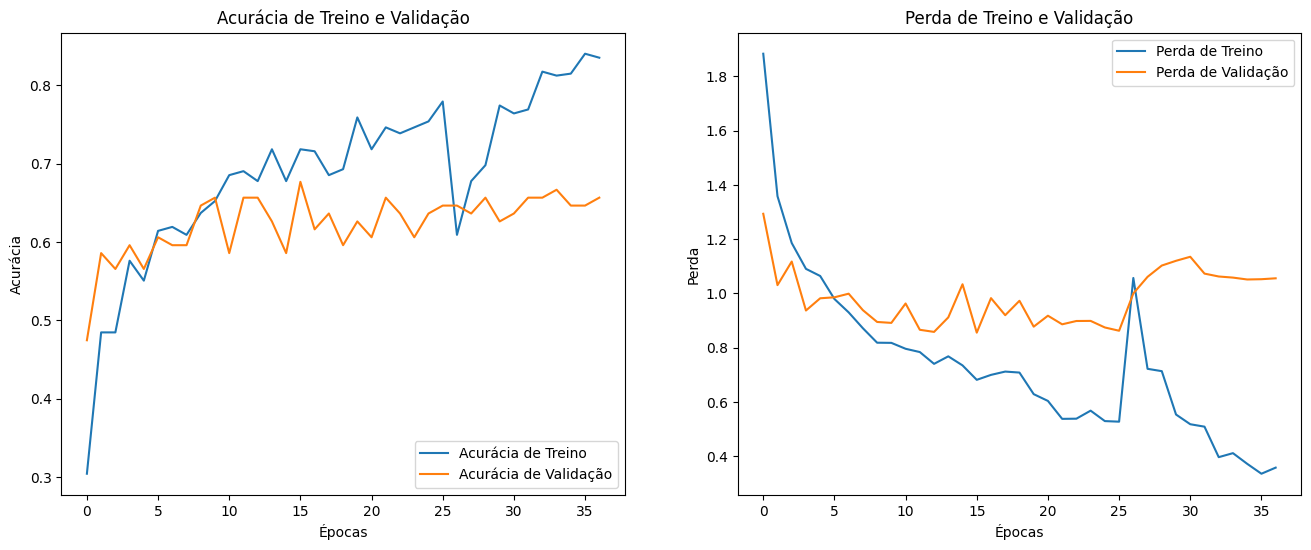

In [ ]:
# ==============================================================================
# PASSO 6: PREPARAÇÃO E EXECUÇÃO DO FINE-TUNING
# ==============================================================================
print("\n--- Iniciando Passo 6: Fine-Tuning ---")

# Descongela as últimas N camadas do modelo base para um ajuste fino.
base_model = model.layers[0]
base_model.trainable = True

for layer in base_model.layers[:-NUM_LAYERS_TO_UNFREEZE]:
    layer.trainable = False

print(f"\nModelo base descongelado. As últimas {NUM_LAYERS_TO_UNFREEZE} camadas agora são treináveis.")

# Re-compila o modelo com uma taxa de aprendizado muito mais baixa.
# Isso é CRUCIAL para não destruir os pesos pré-treinados.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Define novos callbacks para o fine-tuning.
fine_tune_callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath=FINE_TUNE_CHECKPOINT_PATH, monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
]

print("\nIniciando o treinamento de Fine-Tuning...")

# Continua o treinamento a partir de onde o anterior parou.
initial_epochs = len(history.epoch)

fine_tune_history = model.fit(
    train_generator,
    epochs=initial_epochs + FINE_TUNE_EPOCHS,
    initial_epoch=initial_epochs, # Continua a contagem das épocas.
    validation_data=validation_generator,
    class_weight=class_weights_dict, # Continua usando os pesos.
    callbacks=fine_tune_callbacks
)

print("-" * 50)
print(f"Fine-Tuning concluído. O melhor modelo refinado foi salvo em '{FINE_TUNE_CHECKPOINT_PATH}'.")


# ==============================================================================
# AVALIAÇÃO FINAL (VISUALIZAÇÃO PÓS-FINE-TUNING)
# ==============================================================================

# Combina o histórico do treinamento inicial com o do fine-tuning para um gráfico completo.
history.history['accuracy'].extend(fine_tune_history.history['accuracy'])
history.history['val_accuracy'].extend(fine_tune_history.history['val_accuracy'])
history.history['loss'].extend(fine_tune_history.history['loss'])
history.history['val_loss'].extend(fine_tune_history.history['val_loss'])

# Plota os gráficos combinados.
plotar_historico(history)


--- Iniciando Passo 5: Análise do Melhor Modelo do Treino Inicial ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step

Relatório de Classificação:
              precision    recall  f1-score   support

          a2       0.87      0.71      0.78        55
           d       1.00      0.22      0.36         9
           e       0.36      0.33      0.35        12
           g       0.46      0.83      0.59        23

    accuracy                           0.65        99
   macro avg       0.67      0.52      0.52        99
weighted avg       0.72      0.65      0.65        99



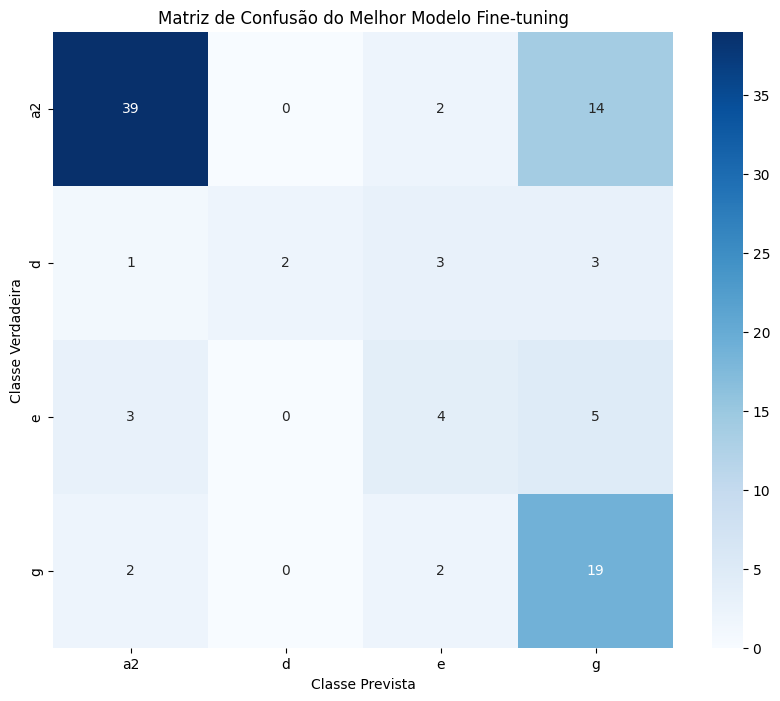

In [ ]:

BEST_MODEL_PATH = 'best_model_fine_tuned.keras'

# ==============================================================================
# PASSO 5: ANÁLISE DETALHADA DO MELHOR MODELO INICIAL
# ==============================================================================
print("--- Iniciando Passo 5: Análise do Melhor Modelo do Treino Inicial ---")

# Carrega o melhor modelo salvo.
try:
    model = tf.keras.models.load_model(BEST_MODEL_PATH)
except Exception as e:
    print(f"Erro ao carregar o modelo. Verifique se o arquivo '{BEST_MODEL_PATH}' existe e se o treinamento anterior foi concluído.")
    raise e

# Faz predições no conjunto de validação.
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# 1. Relatório de Classificação
# Mostra precisão, recall e f1-score para cada classe.
print("\nRelatório de Classificação:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# 2. Matriz de Confusão
# Mostra visualmente onde o modelo está acertando e errando.
conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusão do Melhor Modelo Fine-tuning')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.show()


### **Relatório Técnico: Classificação de Modos de Ruptura em Corpos de Prova Rochosos via Deep Learning**




O presente estudo teve como objetivo desenvolver e avaliar um modelo de Aprendizado Profundo (Deep Learning) para a classificação automática de diferentes modos de ruptura em corpos de prova rochosos submetidos a ensaios de compressão uniaxial.

#### **Metodologia**

A metodologia foi executada em fases sequenciais, partindo da preparação dos dados até o treinamento e refinamento de uma Rede Neural Convolucional (CNN).

**Preparação do Dataset**

O dataset inicial consistiu em 137 registros de corpos de prova, cada um associado a múltiplas imagens de vistas laterais. As imagens individuais foram extraídas e organizadas em diretórios correspondentes às suas classes de ruptura, resultando em um total de 535 imagens. A análise exploratória revelou um severo desbalanceamento entre as classes, conforme detalhado na Tabela 1.

**Tabela 1: Distribuição das amostras por classe de ruptura.**

| Classe | Contagem de Amostras | % do Total |
| :--- | :--- | :--- |
| **a2** | 70 | 51.1% |
| **g** | 30 | 21.9% |
| **e** | 16 | 11.7% |
| **d** | 12 | 8.8% |
| **a1** | 7 | 5.1% |
| **f** | 2 | 1.5% |

**Definição da Prova de Conceito**

Devido à escassez de dados para as classes `a1` e `f`, foi definida uma prova de conceito focada nas quatro classes mais populosas (`a2`, `g`, `e`, `d`), totalizando 493 imagens para o desenvolvimento do modelo inicial. Os dados foram divididos de forma estratificada em 80% para treino (394 imagens) и 20% para validação (99 imagens).

**Arquitetura do Modelo**

Foi adotada a abordagem de **Aprendizagem por Transferência (Transfer Learning)**, utilizando a arquitetura **MobileNetV2** pré-treinada no dataset ImageNet. Um classificador customizado foi adicionado ao topo do modelo base, consistindo em camadas de `GlobalAveragePooling2D`, `Dropout` para regularização, e `Dense` para a classificação final.

**Estratégia de Treinamento**

O treinamento foi conduzido em duas fases:

* **Fase 1 - Treinamento Inicial:** As camadas do modelo base MobileNetV2 foram congeladas, treinando-se apenas o classificador adicionado. Para mitigar o desbalanceamento, foi aplicada a técnica de `class_weight`, que atribui pesos maiores às classes minoritárias durante o cálculo da função de perda.

* **Fase 2 - Ajuste Fino (Fine-Tuning):** Após o treinamento inicial, as 30 camadas finais do modelo base foram "descongeladas" e o treinamento foi continuado com uma taxa de aprendizado 10 vezes menor. O objetivo desta fase foi especializar o modelo nas características sutis das imagens do projeto.

#### **Resultados e Análise**

A avaliação do modelo foi realizada em ambas as fases, com os seguintes resultados para o conjunto de validação.

**Desempenho do Modelo Inicial**

O primeiro modelo atingiu uma acurácia geral de **70%**. A análise detalhada (Tabela 2) e a matriz de confusão revelaram um bom desempenho para a classe `a2`, mas uma performance significativamente inferior para as classes minoritárias, com um forte viés de predição para a classe `a2` em casos de incerteza.

**Desempenho do Modelo Pós-Ajuste Fino**

Após o Fine-Tuning, a acurácia geral foi de **66%**. Embora a métrica global tenha diminuído, a análise qualitativa revelou um modelo mais equilibrado.

**Tabela 2: Comparativo do Recall por classe entre os modelos.**

| Classe | Recall - Modelo Inicial | Recall - Modelo Pós-Fine-Tuning | Variação |
| :--- | :--- | :--- | :--- |
| **a2** | 91% | 78% | 🔻 -13 pts |
| **d** | 33% | 22% | 🔻 -11 pts |
| **e** | 25% | 25% | ▬ 0 pts |
| **g** | 57% | **74%** | ▲ **+17 pts** |

A análise evidencia que o Fine-Tuning reduziu o viés do modelo para a classe `a2`, resultando em uma melhora substancial na sua capacidade de identificar corretamente a segunda classe mais comum, `g`. A queda na acurácia geral é atribuída à redução da performance na classe `a2`, que não é mais prevista de forma tão agressiva. As classes `d` e `e` permaneceram como um desafio devido à alta escassez de dados.

#### **Conclusões**

O estudo confirmou a viabilidade da utilização de modelos de Deep Learning para a classificação de modos de ruptura de rochas. O principal desafio identificado é a limitação e o desbalanceamento do dataset. A estratégia de Fine-Tuning foi eficaz em criar um modelo mais balanceado e menos propenso a "chutar" a classe majoritária, tornando-o potencialmente mais útil para uma aplicação prática. O modelo `best_model_fine_tuned.keras` representa o artefato de melhor desempenho gerado nesta fase do projeto.

#### **Próximos Passos Propostos**

Com base nos resultados obtidos, as seguintes etapas são recomendadas para a continuação do projeto:

1.  **Implementação Prática:** Desenvolver uma função ou aplicação simples para utilizar o modelo refinado na classificação de novas imagens, validando seu comportamento em dados completamente novos.
2.  **Expansão do Modelo:** Investigar a inclusão da classe `a1` no treinamento, empregando técnicas de Data Augmentation mais agressivas para compensar o baixo número de amostras.



Para aprimorar o desempenho do modelo atual e mitigar as limitações observadas, as seguintes ações de otimização e melhoria de performance são recomendadas.

**Ajuste de Hiperparâmetros**
A performance de um modelo de Deep Learning é sensível às configurações utilizadas durante o treinamento, conhecidas como hiperparâmetros. A experimentação sistemática com estes valores pode levar a ganhos de performance significativos. Os principais candidatos para ajuste são:
* **Taxa de Aprendizado (Learning Rate):** Testar valores ligeiramente maiores ou menores (ex: `5e-5` ou `1e-3`) pode permitir que o otimizador encontre um mínimo melhor na função de perda.
* **Taxa de Dropout:** Aumentar ou diminuir a taxa de dropout pode ajudar a encontrar um balanço mais eficaz entre o aprendizado dos padrões e a regularização contra o overfitting.
* **Número de Camadas Descongeladas:** O valor de 30 camadas para o Fine-Tuning foi uma escolha empírica. Testar a performance descongelando um número maior ou menor de camadas (ex: 20, 40 ou 50) pode revelar uma configuração ótima para a especialização do modelo.

**Experimentação com Outras Arquiteturas de Modelo**
A arquitetura MobileNetV2 foi escolhida por sua eficiência, mas outras arquiteturas pré-treinadas podem ter aprendido representações de características mais adequadas para este problema específico. A substituição do modelo base é uma etapa avançada para buscar um novo patamar de acurácia. Arquiteturas recomendadas para experimentação incluem:
* **`EfficientNetV2`:** Uma família de modelos modernos conhecidos por alcançar alta acurácia com grande eficiência computacional.
* **`ResNet50`:** Uma arquitetura clássica e extremamente robusta, cujas conexões residuais permitem o treinamento eficaz de redes muito profundas, podendo capturar padrões mais complexos.
* **`DenseNet`:** Uma arquitetura que conecta cada camada a todas as camadas subsequentes, melhorando o fluxo de gradientes e a reutilização de características.

**Coleta de Mais Dados (Ação de Maior Impacto)**
Constata-se que a principal limitação do projeto é a quantidade e o desbalanceamento dos dados. Modelos de Deep Learning são inerentemente "famintos por dados", e sua performance é diretamente proporcional à qualidade e volume do dataset de treinamento.
* **Foco Estratégico:** A ação de maior impacto seria a coleta de novas amostras, com foco especial nas **classes minoritárias** (`d` e `e`), que o modelo demonstrou maior dificuldade em aprender.
* **Benefício Esperado:** Um aumento no número de exemplos para estas classes permitiria ao modelo aprender seus padrões visuais de forma mais robusta, reduzindo a confusão com as classes majoritárias e elevando significativamente todas as métricas de desempenho (precisão, recall e acurácia geral). Nenhuma otimização de hiperparâmetros ou arquitetura pode substituir o impacto positivo de um dataset maior e mais equilibrado.